<a href="https://colab.research.google.com/github/ParthivRB/Deeptrack_Colab/blob/main/Testing_Deeptrack_PB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tracking Multiple Particles with a U-net

<a href="https://colab.research.google.com/github/DeepTrackAI/DeepTrack2/blob/develop/tutorials/1-getting-started/DTGS131_tracking_multiple_particles_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deeplay deeptrack  # Uncomment if running on Colab/Kaggle.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.3/177.3 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.6/195.6 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.9/827.9 kB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.8/306.8 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 63.1 MB/s eta 0:00:00
  Created wheel for lazy_import: filename=lazy_import-0.2.2-py2.py3-none-any.whl s

This tutorial demonstrates how to track multiple particles using a U-net with DeepTrack 2.

The U-net receives as input an image that may or may not contain particles and outputs an image whose pixels represent the (pseudo)probability that there is a particle nearby. Specifically, each pixel has a value between 0 (high confidence that there is no particle close by) and 1 (high confidence that there is a nearby particle).

In [ ]:
import deeptrack as dt
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.12/dist-packages/deeptrack/__init__.py:14: UserWarning: TensorFlow is detected in your environment. DeepTrack2 version 2.0++ no longer supports TensorFlow. If you need TensorFlow support, please install the legacy version 1.7 of DeepTrack2:

    pip install deeptrack==1.7

For more details, refer to the DeepTrack documentation.
  warnings.warn(


## 1. Defining the Particle

For this example, you consider point particles (point light scatterers). A point particle is an instance of the `PointParticle` class, defined by its intensity and its position. Here, the position is randomized using a lambda function. More details can be found in the tutorial [DTGS121_tracking_particle_cnn](DTGS121_tracking_particle_cnn.ipynb).

In [ ]:
particle = dt.PointParticle(
    intensity=100,
       position=lambda: np.random.rand(2) * 256,
)

## 2. Defining the Optical System

Next, you need to define the properties of the optical system. This is done using an instance of the `Fluorescence` class, which takes a set of light scatterers (particles) and convolves them with the pupil function (point spread function) of the optical system. More details can be found in the tutorial [DTGS121_tracking_particle_cnn](DTGS121_tracking_particle_cnn.ipynb).

In [ ]:
fluorescence_microscope = dt.Fluorescence(
    NA=1.2,
    resolution=4e-7,
    magnification=10,
    wavelength=680e-9,
    output_region=(0, 0, 256, 256)
)

## 3. Defining Noises

You will introduce two sources of noise (see also [DTAT327_noises](../3-advanced-topics/DTAT327_noises.ipynb)):

1. A background random offset between 0 and 1.

2. A Poisson noise with a random SNR between 3 and 10.

In [ ]:
offset = dt.Add(
    value=lambda: np.random.rand() * 1
)

poisson_noise = dt.Poisson(
    snr=lambda: np.random.rand() * 7 + 3,
    background=offset.value
)

## 4. Defining the Image Features

You want images with a random number of particles between 1 and 10, a background offset, and Poisson noise.

In [ ]:
num_particles = lambda: np.random.randint(1, 11)

image_features = (
    fluorescence_microscope(particle ^ num_particles)
    >> offset
    >> poisson_noise
)

## 5. Plotting Some Example Images

Now, you can visualize some example images. At each iteration, call the method `.update()` to refresh the random features in the image (particle number, particle positions, offset level, and Poisson noise). Afterwards, call the method `.plot()` to generate and display the image.

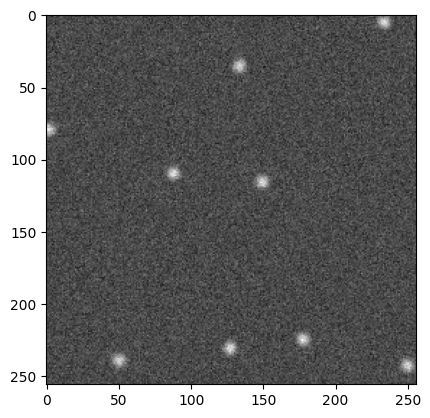

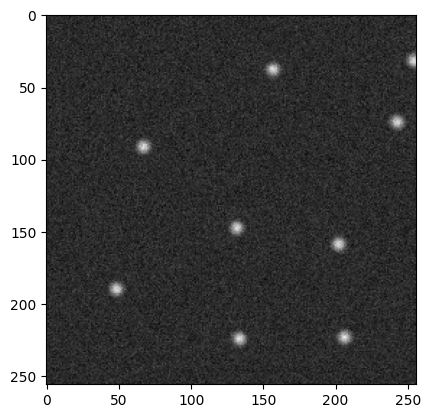

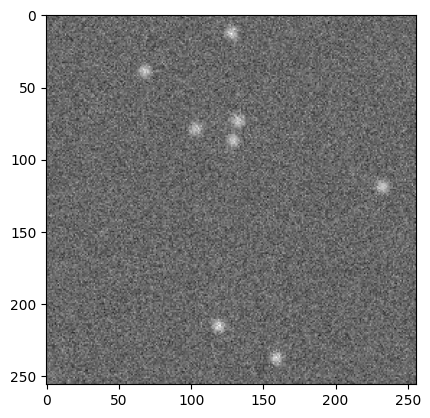

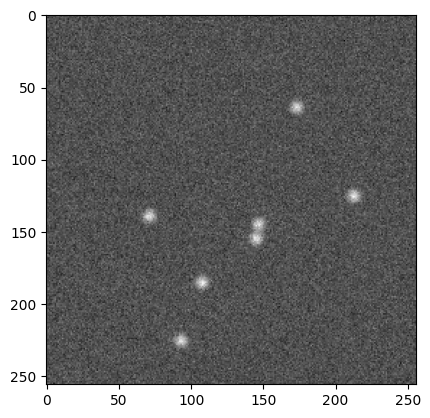

In [ ]:
for i in range(4):
    image_features.update()
    output_image = image_features.plot(cmap="gray")
    plt.show()



## 6. Creating the Target Images

You now need to define a function that uses the generated images to create the target images to be used in the training. Here, the target image is a binary image, where each pixel is `1` if it is within `CIRCLE_RADIUS` distance from any particle in the input image, and 0 otherwise.

In [ ]:
image_features.store_properties()  # Store the properties of the particles.

circle_radius = 3

def get_target_image(image_of_particles):
    """Create a binary image with the circles in the particle positions. """

    target_image = np.zeros(image_of_particles.shape)
    x, y = np.meshgrid(
        np.arange(0, image_of_particles.shape[0]),
        np.arange(0, image_of_particles.shape[1])
    )

    for property in image_of_particles.properties:
        if "position" in property:
            position = property["position"]

            distance_map = (x - position[1]) ** 2 + (y - position[0]) ** 2
            target_image[distance_map < circle_radius ** 2] = 1

    return target_image

You can now plot images and targets side by side.

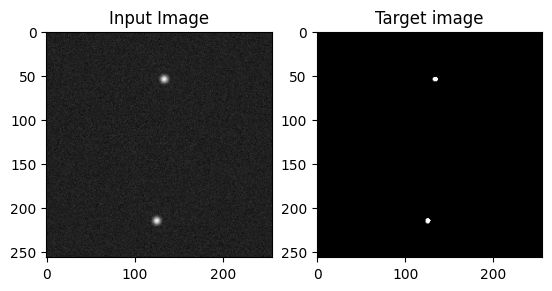

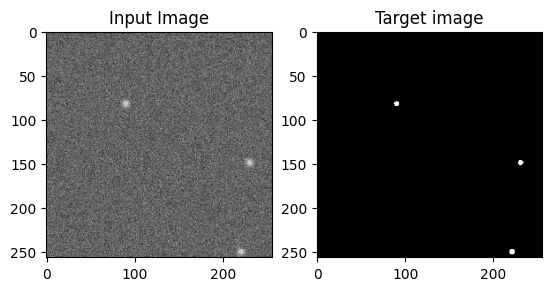

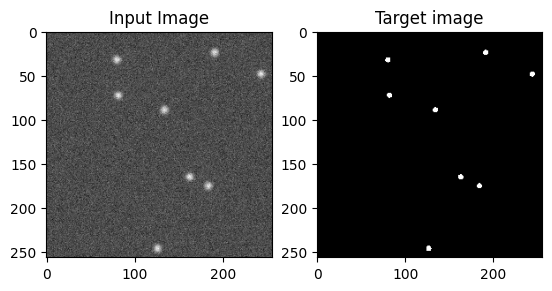

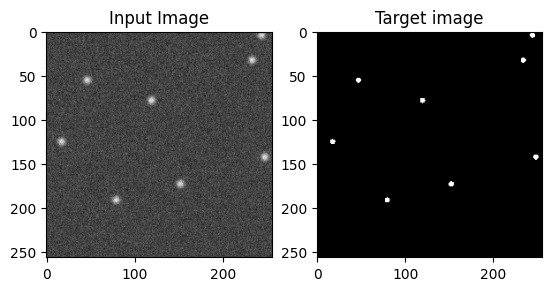

In [ ]:
for i in range(4):

    image_features.update()
    image_of_particles = image_features.resolve()

    target_image = get_target_image(image_of_particles)

    plt.subplot(1,2,1)
    plt.imshow(np.squeeze(image_of_particles), cmap="gray")
    plt.title("Input Image")

    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(target_image), cmap="gray")
    plt.title("Target image")

    plt.show()

## 8. Defining the Neural Network Model

The neural network architecture used is a U-Net, which is a fully convolutional model used for image-to-image transformations.

Since the desired output is a binary image, you will use crossentropy as the loss function. Furthermore, since the target image is disproportionaly populated by 0s (any pixel is much more likely to be a zero than a one), you need to weight the loss such that false negatives are penalized ten times more than the false positives.

The model can be customized by passing the following arguments:

- `input_shape`: Size of the images to be analyzed. The first two values can be set to `None` to allow arbitrary sizes.

- `conv_layers_dimensions`: Number of convolutions in each convolutional layer during down- and upsampling.
    
- `base_conv_layers_dimensions`: Number of convolutions in each convolutional layer at the base of the unet, where the image is the most downsampled.

- `output_conv_layers_dimensions`: Number of convolutions in each convolutional layer after the upsampling.
    
- `steps_per_pooling`: Number of convolutional layers between each pooling and upsampling step.

- `number_of_outputs`: Number of convolutions in output layer.

- `output_activation`: The activation function of the output.

- `loss`: The loss function of the network.

- `optimizer`: The the optimizer used for training.

- `metrics`: Additional metrics to evaulate during training.

In [ ]:
import deeptrack.deeplay as dl
import torchmetrics as tm

data_pipeline = image_features & (image_features >> get_target_image)

net = dl.UNet2d(
    in_channels=1,
    channels=[16, 32, 64],
    out_channels=1,
)

weight = dl.torch.tensor([500])
model = dl.Regressor(
    net,
    loss=dl.torch.nn.BCEWithLogitsLoss(pos_weight=weight),
    optimizer=dl.optimizers.Adam(lr=1e-4),
    metrics=[tm.F1Score(task="binary")],
)

## 9. Training the Model

The model is trained by calling `.fit()`. This will take a few minutes.

In [ ]:
h = model.fit(
    train_data=data_pipeline,
    val_data=data_pipeline,
    max_epochs=100,
    steps_per_epoch=25,
    val_steps_per_epoch=5,
    accelerator="auto",
)

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ BCEWithLogitsLoss │      0 │ train │
│ 1 │ train_metrics │ MetricCollection  │      0 │ train │
│ 2 │ val_metrics   │ MetricCollection  │      0 │ train │
│ 3 │ test_metrics  │ MetricCollection  │      0 │ train │
│ 4 │ model         │ UNet2d            │  128 K │ train │
│ 5 │ optimizer     │ Adam              │      0 │ train │
└───┴───────────────┴───────────────────┴────────┴───────┘

Trainable params: 128 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 128 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 45                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches 
(25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

You can now plot the training history.

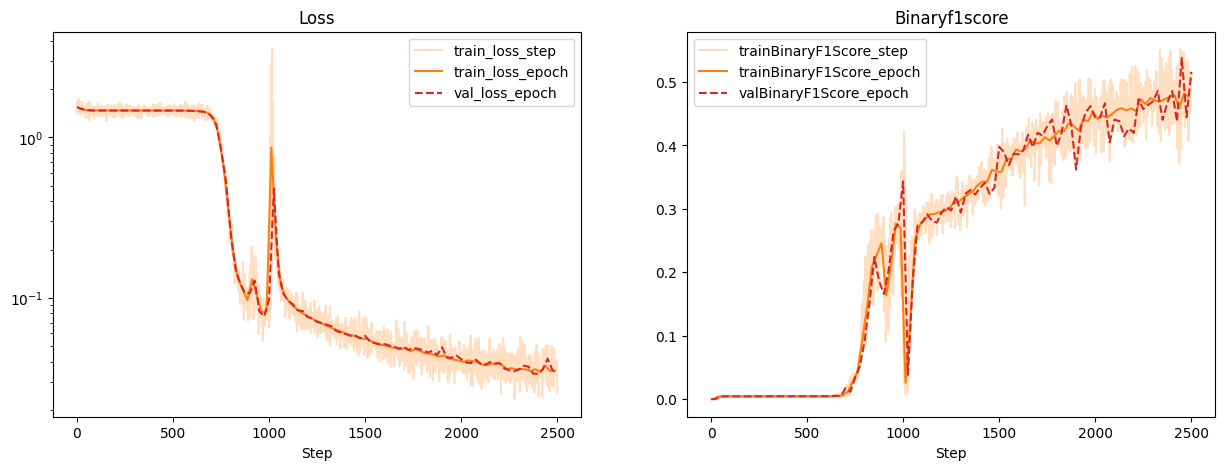

In [ ]:
fig, ax = h.plot()
ax[0].set_yscale("log")
ax[1].set_yscale("linear")

## 10. Visualizing the Model Performance

Finally, you can evaluate the model performance by showing the model output besides the input image and the target image.

380.0232558139535


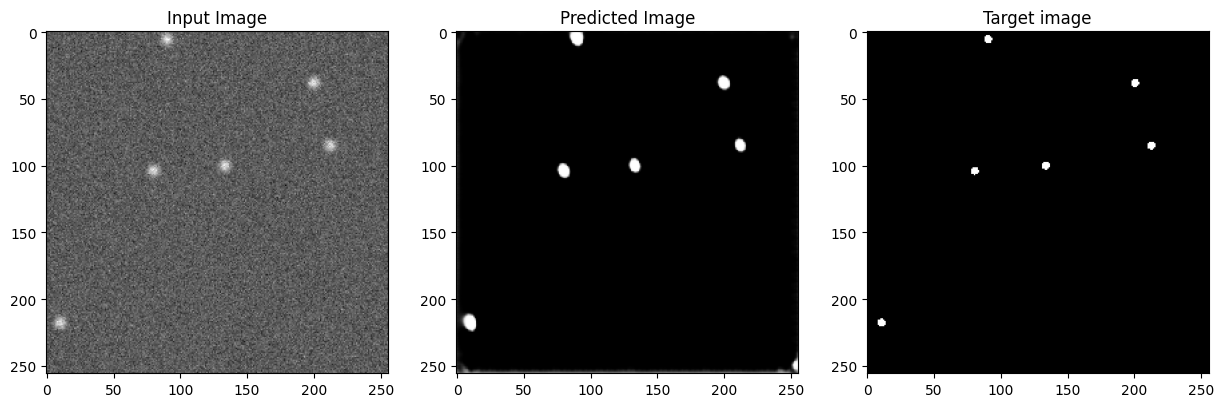

283.9391304347826


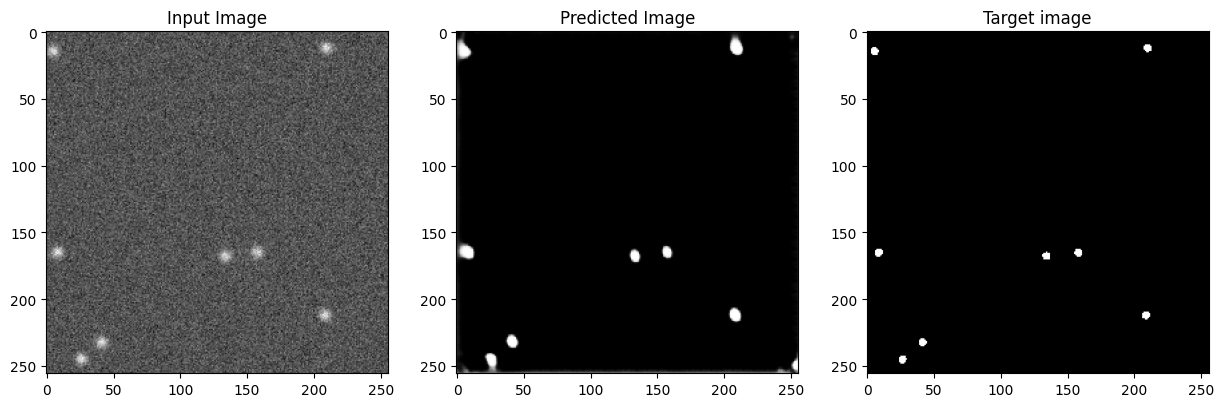

798.219512195122


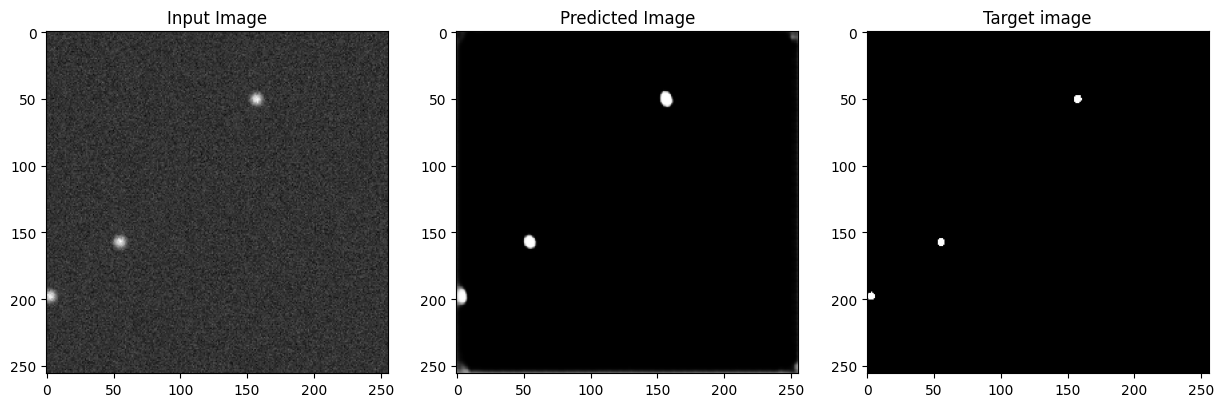

232.22419928825622


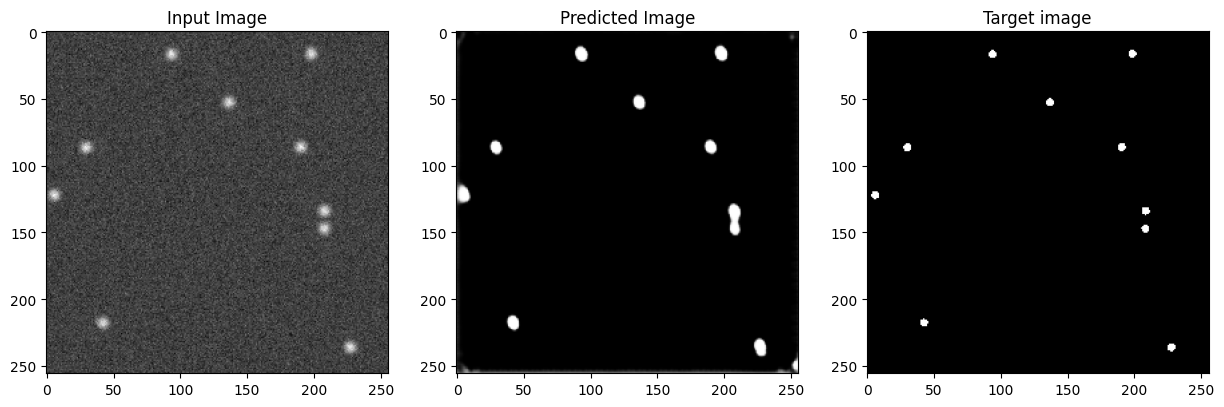

In [ ]:
images, targets = data_pipeline.batch(4)
predicted_probabilities = \
    model.predict(np.transpose(images,(0,3,2,1)).astype(np.float32)).sigmoid()

for i in range(4):

    plt.figure(figsize=(15, 5))

    plt.subplot(1,3,1)
    plt.imshow(images[i, ..., 0].squeeze(), cmap="gray")
    plt.title("Input Image")

    plt.subplot(1,3,2)
    plt.imshow(predicted_probabilities[i, 0, ...].T, cmap="gray")
    plt.title("Predicted Image")

    plt.subplot(1,3,3)
    plt.imshow(targets[i], cmap="gray")
    plt.title("Target image")
    print((targets[i] == 0).sum() / (targets[i] == 1).sum())

    plt.show()

In [ ]:
dl.torch.save(net.state_dict(), "my_deeptrack_model.pth")

In [ ]:
import os
print(os.path.exists("my_deeptrack_model.pth"))

True


In [ ]:
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import deeptrack.deeplay as dl # Import deeplay to access torch and UNet2d

# Load the stacked TIFF file
stack = tiff.imread("/content/10%PEG-Tf-NP_092525_50.oir - C=0.tif")  # shape: (num_frames, height, width)

# Normalize and reshape if needed
stack = stack.astype("float32") / 255.0  # normalize to [0, 1]

# Add batch and channel dimensions if needed to ensure (N, H, W, C) format
if stack.ndim == 2:  # Grayscale image (H, W)
    stack = np.expand_dims(stack, axis=(0, -1))  # -> (1, H, W, 1)
elif stack.ndim == 3: # Stack of grayscale images (N, H, W)
    stack = np.expand_dims(stack, axis=-1)       # -> (N, H, W, 1)
# If stack.ndim is already 4, it's already (N, H, W, C)

# Initialize the UNet2d model with the same architecture as during training
# This assumes the 'net' variable in cell 'aBV16I5bg4co' defined the U-Net architecture.
net = dl.UNet2d(
    in_channels=1,
    channels=[16, 32, 64],
    out_channels=1,
)

# Load the state dictionary into the initialized model, ignoring unexpected keys
net.load_state_dict(dl.torch.load("my_deeptrack_model.pth"), strict=False)
net.eval() # Set the model to evaluation mode

# Convert numpy stack to torch tensor and change shape for PyTorch model (Batch, Channel, Height, Width)
stack_tensor = dl.torch.from_numpy(np.transpose(stack, (0, 3, 1, 2))) # PyTorch expects (N, C, H, W)

# Predict on the entire stack
# Use no_grad for inference to save memory and computations
with dl.torch.no_grad():
    predictions_tensor = net(stack_tensor)
    # Apply sigmoid as the original model uses BCEWithLogitsLoss
    predictions_tensor = dl.torch.sigmoid(predictions_tensor)

# Convert predictions back to numpy for plotting (Batch, Height, Width, Channel)
predictions = np.transpose(predictions_tensor.cpu().numpy(), (0, 2, 3, 1))

# Inspect results
print(predictions.shape)

# Show first frame and prediction
plt.subplot(1, 2, 1)
plt.imshow(stack[0].squeeze(), cmap="gray")
plt.title("Input Frame")

plt.subplot(1, 2, 2)
plt.imshow(predictions[0].squeeze(), cmap="gray")
plt.title("Model Output")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/10%PEG-Tf-NP_092525_50.oir - C=0.tif'

In [ ]:
import os
print(os.listdir('.'))

In [ ]:
!pip install trackpy

In [ ]:
from scipy.ndimage import label, center_of_mass

threshold = 0.5
trajectories = []

for t, frame in enumerate(predictions):
    binary = frame.squeeze() > threshold
    labeled, num_features = label(binary)
    centers = center_of_mass(binary, labeled, range(1, num_features + 1))
    for i, (y, x) in enumerate(centers):
        trajectories.append({"frame": t, "id": None, "x": x, "y": y})

In [ ]:
import pandas as pd
import trackpy as tp

df = pd.DataFrame(trajectories)
linked = tp.link_df(df, search_range=1, memory=2)  # Reduced `search_range` to 1

In [ ]:
tp.plot_traj(linked)
plt.title("Particle Trajectories")
plt.show()

In [ ]:
# 'linked' is your DataFrame with columns like: frame, particle, x, y
linked.to_csv("particle_trajectories.csv", index=False)

In [ ]:
from google.colab import files
files.download("particle_trajectories.csv")

In [ ]:
# Calculate ensemble MSD
emsd = tp.motion.emsd(linked, mpp=0.4, fps=30)

# # Plot ensemble MSD vs. lag time
# plt.figure(figsize=(8, 5))
# plt.plot(emsd.index, emsd['<r>'], marker='o')
# plt.xlabel('Lag time (frames)')
# plt.ylabel('Ensemble MSD (µm²)')
# plt.title('Ensemble Mean Squared Displacement vs. Lag Time')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [ ]:
print(emsd)

In [ ]:
average_msd = np.mean(emsd.values)
print(average_msd)

In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(8, 5))
# plt.plot(emsd.index, emsd.values, marker='o', linestyle='-')
# plt.xlabel('Lag time (seconds)')
# plt.ylabel(f'MSD ({emsd.name})')  # Optional: shows the name of the Series
# plt.title('Ensemble MSD vs. Lag Time')
# plt.grid(True)
# plt.tight_layout()
# plt.show()


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Load your CSV file
# df = pd.read_csv("particle_trajectories.csv")  # Not needed for MSD calculation from emsd Series

# Assume columns are 'lag_time' and 'msd'
t = emsd.index.values # Use the index of the emsd Series for lag times
msd = emsd.values     # Use the values of the emsd Series for MSD

# Fit only the first N points (e.g., first 10)
N = 10
t_fit = t[:N]
msd_fit = msd[:N]

# Define models
def linear_model(t, D, offset):
    return 4 * D * t + offset

def power_law(t, A, alpha):
    return A * t**alpha

# Fit models
params_lin, _ = curve_fit(linear_model, t_fit, msd_fit)
D_est, offset = params_lin

params_pow, _ = curve_fit(power_law, t_fit, msd_fit)
A_est, alpha_est = params_pow

# Print results
print(f"Estimated diffusion coefficient: D = {D_est:.4f} µm²/s")
print(f"Linear offset: {offset:.4f} µm²")
print(f"Anomalous diffusion exponent: α = {alpha_est:.2f}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(t, msd, 'o', label='MSD data')
plt.plot(t_fit, linear_model(t_fit, *params_lin), '-', label='Linear fit')
plt.plot(t_fit, power_law(t_fit, *params_pow), '--', label='Power-law fit')
plt.xlabel('Lag time (seconds)')
plt.ylabel('MSD (µm²)')
plt.title('MSD with Linear and Power-law Fits')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# import numpy as np, pandas as pd
# from skimage import io, measure, filters, morphology
# import tensorflow as tf
# import matplotlib.pyplot as plt
# import math

# MODEL_PATH = "my_deeptrack_model.pth"
# TIFF_PATH  = "processed contrast.tif"
# THRESH     = 0.5          # sigmoid threshold; adjust if needed
# MIN_AREA   = 3            # remove tiny specks
# FOV        = 128          # must match training input; if your frames

# # --- Load model ---
# model = tf.keras.models.load_model(MODEL_PATH, compile=False)

# # --- Load TIFF (T x H x W) or (H x W) ---
# stack = io.imread(TIFF_PATH)
# if stack.ndim == 2:
#     stack = stack[None, ...]        # make it (T, H, W)

# T, H, W = stack.shape
# print(f"TIFF loaded: {T} frames, {H}x{W}px")

# def normalize(img):
#     img = img.astype("float32")
#     rng = img.max() - img.min()
#     return (img - img.min()) / (rng if rng > 0 else 1.0)

# def tile_predict(frame, F=FOV):
#     """If frame is bigger than FOV, do sliding-window inference and stitch."""
#     if frame.shape == (F, F):
#         inp = frame[None, ..., None]
#         pred = model.predict(inp, verbose=0)[0, ..., 0]
#         return pred

#     # pad to multiples of F
#     pad_y = (F - (frame.shape[0] % F)) % F
#     pad_x = (F - (frame.shape[1] % F)) % F
#     fr_p = np.pad(frame, ((0,pad_y),(0,pad_x)), mode="reflect")
#     H2, W2 = fr_p.shape
#     out = np.zeros_like(fr_p, dtype="float32")

#     # optional: simple feathering via count map
#     count = np.zeros_like(fr_p, dtype="float32")

#     for y in range(0, H2, F):
#         for x in range(0, W2, F):
#             patch = fr_p[y:y+F, x:x+F]
#             pred = model.predict(patch[None, ..., None], verbose=0)[0, ..., 0]
#             out[y:y+F, x:x+F] += pred
#             count[y:y+F, x:x+F] += 1.0

#     out = out / np.maximum(count, 1e-6)
#     # crop back
#     return out[:frame.shape[0], :frame.shape[1]]

# rows = []
# all_masks = []

# for t in range(T):
#     fr = normalize(stack[t])
#     pred = tile_predict(fr, F=FOV)

#     # threshold + clean
#     if THRESH is None:
#         thr = filters.threshold_otsu(pred)
#     else:
#         thr = THRESH
#     mask = (pred >= thr).astype(np.uint8)
#     mask = morphology.remove_small_objects(mask.astype(bool), min_size=MIN_AREA)
#     mask = morphology.binary_opening(mask, morphology.disk(1))
#     mask = mask.astype(np.uint8)

#     # centroids from connected components
#     lab = measure.label(mask, connectivity=1)
#     props = measure.regionprops(lab)
#     for p in props:
#         y, x = p.centroid       # note: (row, col) = (y, x)
#         area = p.area
#         rows.append(dict(frame=t, x=float(x), y=float(y), area=int(area)))

#     all_masks.append(mask)

# # save detections
# df = pd.DataFrame(rows)
# df.to_csv("detections_from_unet.csv", index=False)
# print(f"Saved centroids -> detections_from_unet.csv (n={len(df)})")

# # optional: save a quick overlay for sanity check on a mid frame
# mid = T//2
# plt.figure(figsize=(10,4))
# plt.subplot(1,2,1); plt.title("Input");
# plt.imshow(normalize(stack[mid]), cmap="gray"); plt.axis("off")
# plt.subplot(1,2,2); plt.title("Pred mask"); plt.imshow(all_masks[mid],
# cmap="magma"); plt.axis("off")
# plt.tight_layout(); plt.savefig("overlay_example.png", dpi=180)
# print("Saved overlay_example.png")

In [ ]:
import torch
from google.colab import files

# 1. Define the filename
save_name = 'my_deeptrack_model.pth'

# 2. Save the trained model's weights
# Note: In most DeepTrack tutorials, the model variable is named 'model' or 'generated_model'.
# If this fails, try changing 'model' to 'u_net' or check the previous cells for the variable name.
torch.save(model.state_dict(), save_name)

# 3. Download the file to your computer
files.download(save_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>